<a href="https://colab.research.google.com/github/lucas-fpaiva/tcc_pes/blob/main/preprocessing/maintenance_loc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extratégias para identificar quebras nas séries temporais

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import plotly as py
import matplotlib.gridspec as gridspec
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
print("Estou rodando no Colab (S/N)?")
ambiente = input()
ambiente=ambiente.upper()

if ambiente == "S":
  from google.colab import drive
  import os

  drive.mount('/content/drive',force_remount=True)
  os.chdir('/content/drive/Shareddrives/TCC_PES/codigos')

Estou rodando no Colab (S/N)?
S
Mounted at /content/drive


In [3]:
data_health = pd.read_csv('saude.csv')

data_health = data_health.groupby(by=['COD_FALH','COD_AENV','DT_PROC']).median().reset_index()
data_health['id']=data_health.index
data_health.head()

np.random.seed(123)
np.random.randint(0,2,10)
teste = np.random.choice(np.unique(data_health.COD_AENV),2)
print("Aviões usados para teste: ", teste)

data_health  = data_health[data_health.COD_AENV != teste[0]][data_health.COD_AENV != teste[1]]

print("Aviões usados para teste: ", np.unique(data_health.COD_AENV))



Aviões usados para teste:  [9834 9747]
Aviões usados para teste:  [1011 9486 9526 9636 9664 9678 9770 9793]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':


### Vizualização das séries

In [4]:
px.line(data_health[data_health.COD_FALH==23], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

In [5]:
px.line(data_health[data_health.COD_FALH==35], x='DT_PROC', y='VLR_DESG', color='COD_AENV')

## Aborgens para detecção de anomalias


As funções para detecção de anomalias e processamento dos dados podem ser importadas de pre_process. 


Cada uma das funções são apresentadas abaixo

In [6]:
from pre_process import discrepancy_4, loc_discrepancy, proces_data, model_input, data_func

In [7]:
import pandas as pd
import numpy as np

#identifica as diferenças
def discrepancy_4(serie,falh,n=5,reverse=False): 
    # Uso recomendado somente para as falhas 1, 23 e 14
    #Função que identifica diferenças entre duas amostras consecutivas de tamanho n
    #   se a diferença for maior que 3*amplitude, então é considerada uma discrepância
    
    # Além disso, compara a diferença de uma amostra com o ponto seguinte
    #   se a diferença for maior que 2, então é considerada uma discrepância
    
    #Os valores foram ajustados experimentalmente
    
    # n = tamanho da janela
    
    if reverse == True:
        serie = serie[::-1] 

    if falh==35:
        n = 10
    
    
    discrip = [0]*n # inicializa a lista de discrepância
    
    for i in range(len(serie)-n):
        sample1 = serie[i:i+n] # amostra 1
        min1 = np.min(sample1) # minimo da amostra 1
        max1 = np.max(sample1) # maximo da amostra 1
        
        
        sample2 = serie[i+n:i+2*n] # amostra 2
        min2 = np.min(sample2) # minimo da amostra 2
        max2 = np.max(sample2) # maximo da amostra 2
        
        ptp1 = 3*abs(max1-min1) # amplitude da amostra 1
        #ptp2 = 3*abs(max2-min2) # amplitude da amostra 2
        
        lim = 5 # limite para considerar discrepância f35
        
        if falh == 35:
            if(min2>max1+lim or max2<min1-lim): #amostra 2 está fora da amostra 1
                discrip.append(100) #discrepancia
            else: discrip.append(0)
        
        else:
            
            if(min2>max1+ptp1 or max2<min1-ptp1): #amostra 2 está fora da amostra 1
                discrip.append(100) #discrepancia
                
            else: # amostra 2 está dentro da amostra 1
                if serie[i+n] > max1+2 or serie[i+n] < min1-2: # ponto atual está fora da amostra 1
                    discrip.append(100) #discrepancia
                else:
                    discrip.append(0) #sem discrepancia
        
        if reverse == True:
            return np.array(discrip[1,:].append(0))[::-1] 

    return np.array(discrip) #lista de discrepancias
        
        

# Pega as partes uteis da série
def loc_discrepancy(serie,disc1, l_train):
    #Recebe uma série, lista de discrepâncias e um intervalo de amostragem
    #Cada trecho entre discrepâncias é considerado uma nova série
    #Cada nova série recebe um idenficador
    
    #A função retorna uma série cujos trechos menores que o intervalo são substituidos por -1
    #Também retorna uma lista indicando o id de cada ponto da série
    samples = l_train + 10 # tamanho da janela
    d1 = 0
    remove_val = np.copy(serie) 
    parts = []
    part=1
    
    count = 0
    for i in range(0,len(disc1)): #percorre a lista de discrepâncias
        parts.append(part)
        
        if disc1[i]==100 or disc1[i]==200: #se a discrepância for 100 ou 200, o trecho é considerado uma nova série
            part+=1 #incrementa o identificador
            
            if i-d1<samples: #se o trecho for menor que o intervalo de amostragem, substitui por -1
                remove_val[d1:i]=[-3]*len(disc1[d1:i]) #substitui os valores por -1
                d1=i
            else: d1=i
            
    if i-d1<samples: #se o último trecho for menor que o intervalo de amostragem
        remove_val[d1:]=[-3]*len(disc1[d1:]) #substitui os valores por -3
        
    return remove_val, parts 
    #retorna a série com os trechos menores que o intervalo substituidos por -1 e a lista de identificadores
    
    
# Cria um novo banco de dado identificando os trechos das séries
def proces_data(data,l_train,falh):
    fun_dis = discrepancy_4
    #disc = []
    aenv= data.COD_AENV.unique()
    data_f = pd.DataFrame()
    for i in aenv:
        data_A=data[data['COD_AENV']==i].sort_values(by='DT_PROC')
        
        serie=data_A['VLR_DESG'].to_list()
        #id = data_A['id'].to_list()
        
        disc1 = fun_dis(serie,falh) + fun_dis(serie[::-1],falh)[::-1]
        
        data_A['LOC_DISC'] = disc1
        
        serie,parts = loc_discrepancy(serie,disc1,l_train)
        
        data_A['VLR_DESG_new'] = serie
        data_A['SEC'] = parts
        
        #data_A = data_A[data_A.VLR_DESG_new!=-1]
        
        data_A['COD'] = range(0,len(data_A['SEC'].tolist()))
        
        data_f = pd.concat([data_f,data_A])    
        
    return data_f

# cria um banco de dados pronto para ser usado no modelo
def model_input(data_health, l_train,falh):
    data = data_health[data_health.COD_FALH==falh] #filtra o banco de dados por falha
    data_f = proces_data(data,l_train,falh) #cria o banco de dados com os trechos das séries

    l_test = 10 #tamanho da janela de teste (regra de negócio)
    n=l_train+l_test #tamanho da janela total
    train_test = []#lista de trechos de treino e teste
    train_test_time = [] #lista de datas
    treino = [] #lista de trechos de treino
    teste = [] #lista de trechos de teste
    id_trecho=[] #lista de identificadores
    aen_ = [] #lista de aeronaves

    count = 0
    for aenv in data_f.COD_AENV.unique(): #percorre as aeronaves
          for i in data_f[data_f['COD_AENV']==aenv].SEC.unique(): #percorre os trechos das séries
              trecho = data_f[(data_f['COD_AENV']==aenv) & (data_f['SEC']==i)].VLR_DESG.tolist() #pega o trecho
              trecho_time = data_f[(data_f['COD_AENV']==aenv) & (data_f['SEC']==i)].DT_PROC.tolist() #pega as datas reais do trecho
              if len(trecho)>n: #se o trecho for maior que a janela total
                
                  for j in range(len(trecho)-n): #percorre o trecho
                      treino.append(trecho[j:j+l_train]) #pega a janela de treino
                      teste.append(trecho[j+l_train:j+l_train+l_test]) #pega a janela de teste
                      id_trecho.append(i) #pega o identificador do trecho
                      aen_.append(aenv) #pega o identificador da aeronave
                      train_test.append(np.array([*trecho[j:j+l_train],*trecho[j+l_train:j+l_train+l_test],aenv])) #pega o trecho completo
                      train_test_time.append(np.array([*trecho_time[j:j+l_train],*trecho_time[j+l_train:j+l_train+l_test],aenv])) #pega as datas do trecho completo
                      count+=1
    train_test=np.array(train_test) #transforma a lista de trechos em array
    train_test_time=np.array(train_test_time) #transforma a lista de datas em array
                    
    return train_test, train_test_time #retorna o array de trechos e o array de datas


# separa o banco de dados em treino e teste e em x e y
def data_func (train_test, aenv,l_train,deep=True): #deep=True para usar os modelos recorrentes
  sample = l_train+10 #tamanho da janela total
  y_index = l_train+9 #índice do y
  
  #separação treino e teste 
  trainX = train_test[train_test[:,sample]!=aenv][:,:l_train]/100 #separa as entradas de treino
  trainY = train_test[train_test[:,sample]!=aenv][:,y_index]/100 #separa separa as saídas de treino
  testX = train_test[train_test[:,sample]==aenv][:,:l_train]/100 #separa as entradas de teste
  testY = train_test[train_test[:,sample]==aenv][:,y_index]/100 #separa as saídas de teste


  # reshape para treinar os modelos
  if deep==True:
    trainX = np.reshape(trainX, (trainX.shape[0],1, trainX[0].shape[0])) #reshape para treinar os modelos recorrentes
    trainY = np.reshape(trainY, (trainY.shape[0],1, 1)) 
    testX  = np.reshape(testX , (testX.shape[0], 1, testX[0].shape[0])) #reshape para testar os modelos recorrentes
    testY = np.reshape(testY, (testY.shape[0], 1,1))

  return trainX, trainY, testX, testY #retorna os arrays de treino e teste, e as entradas e saídas

In [27]:
# vizualizção das séries e das falhas identificadas
def plot_discrepancy(data, fun_dis,l_train,rever=False):
#Função para plotar as séries e as falhas identificadas

    aenv= data.COD_AENV.unique() # lista de aenvs
    falh= data.COD_FALH.unique() # lista de falhas

    leg = ['Série', 'Trechos','Nova série','Discrepância'] # legenda
    for i in aenv: # loop para cada aenv
        fig = plt.figure(figsize = (20,5),dpi=100)
        axes = gridspec.GridSpec(nrows=1, ncols=4, figure=fig, wspace=0.2, hspace=0.3)
        count=0
       
        for j in falh: # loop para cada falha
            ax=fig.add_subplot(axes[count])
            serie=data[(data['COD_AENV']==i) & (data['COD_FALH']==j)].sort_values(by='DT_PROC')['VLR_DESG'].to_list() # serie da falha
            ax.plot(serie,'k.',linewidth=1,markersize=1)

            disc1=fun_dis(serie,falh=j)
            disc1 = fun_dis(serie,falh=j) + fun_dis(serie[::-1],falh=j)[::-1]

            serie_new, parts = loc_discrepancy(serie,disc1,l_train = l_train)
            
            markerline, stemlines, baseline = ax.stem(disc1, markerfmt=' ',use_line_collection=True, linefmt=':r',basefmt=' ')
            plt.setp(stemlines, 'linewidth', 0.5)
            
            plt.plot(parts,'*b',linewidth=1,markersize=1)
            #plt.xlim([300,400])
            ax.set_ylim([-4,85])
            ax.set_xlabel('Dias desde o início da série')
            ax.set_ylabel('Valor do desgaste')


            ax.plot(serie_new,'om',linewidth=1,markersize=1)

            if count == 0:
              ax.legend(leg)
            ax.set_title('AENV: '+str(i)+' - FALH: '+str(j))# título        

            count+=1

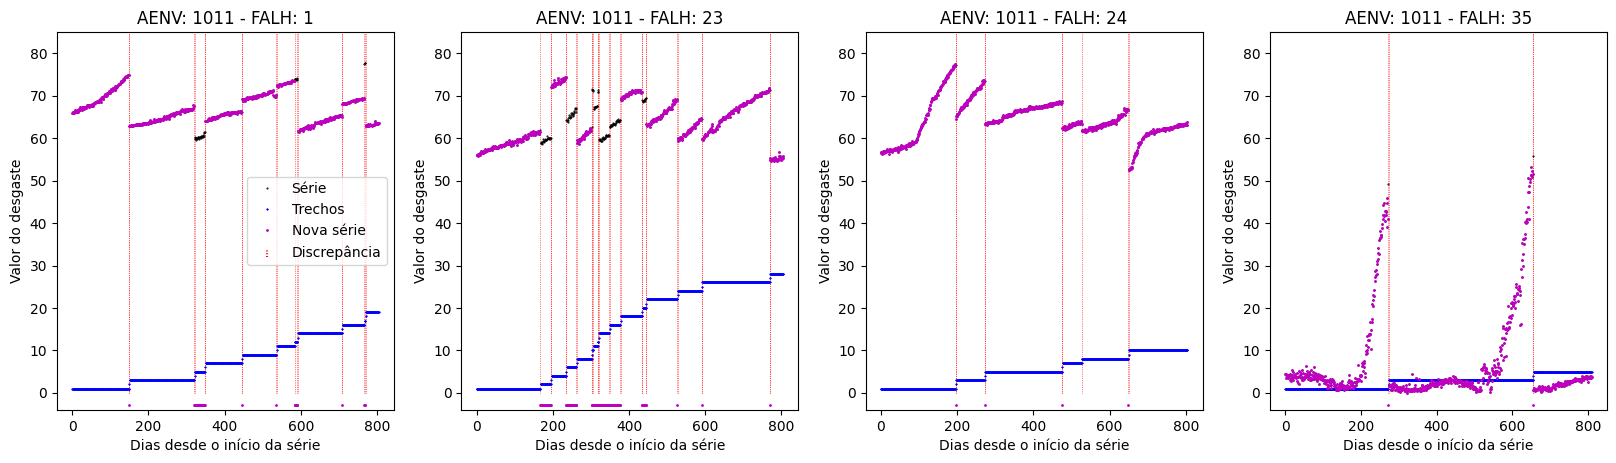

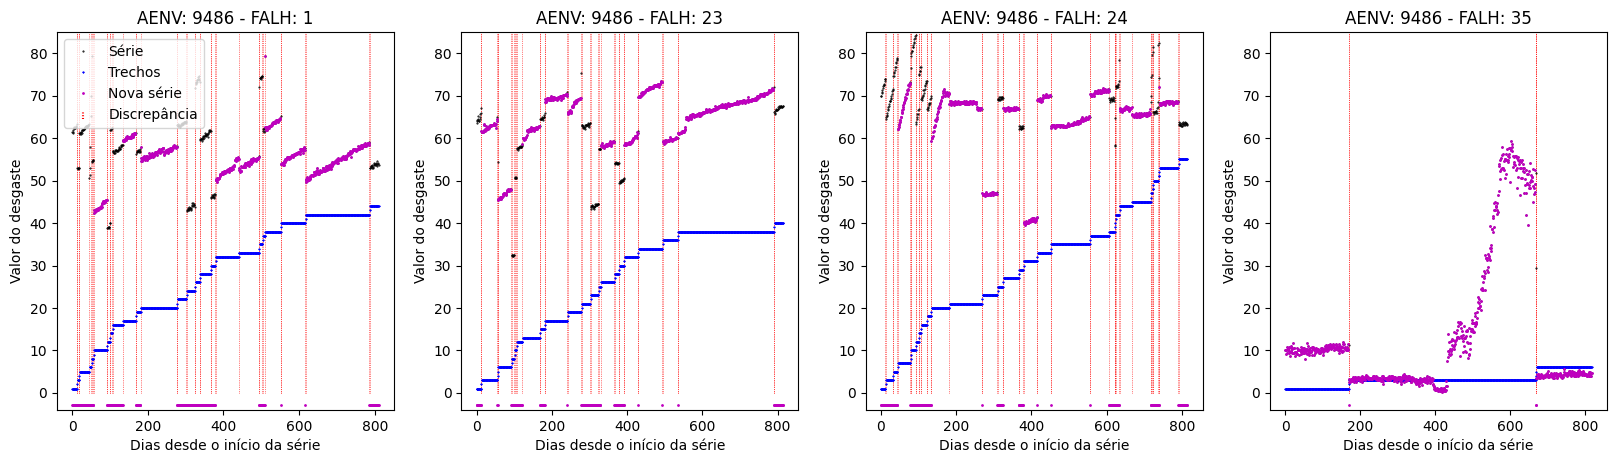

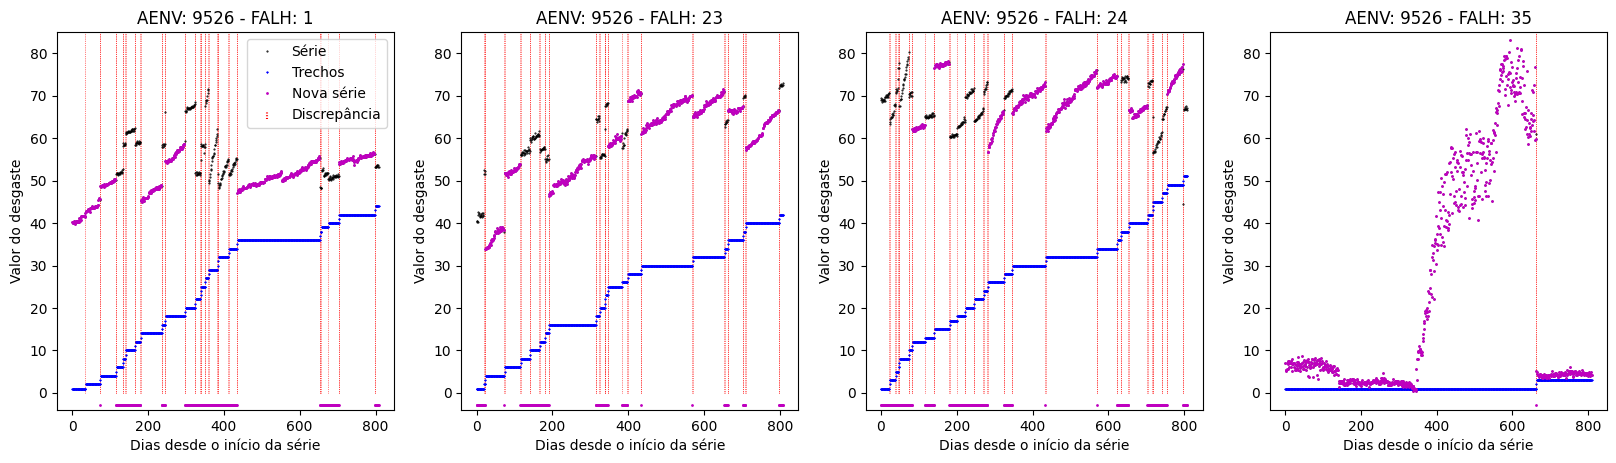

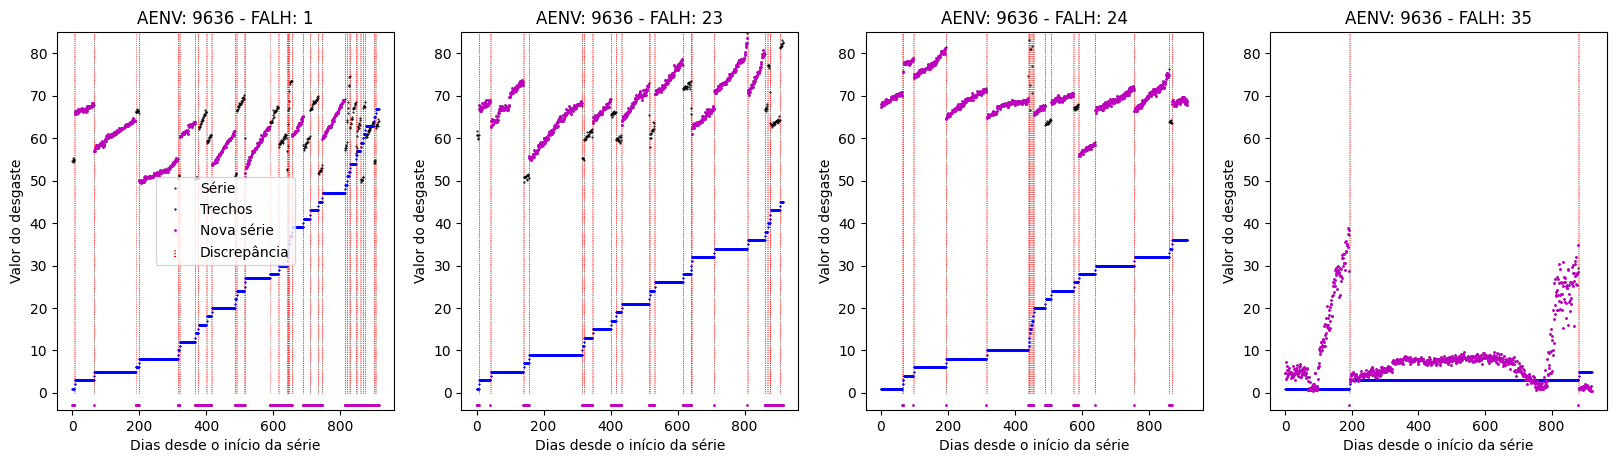

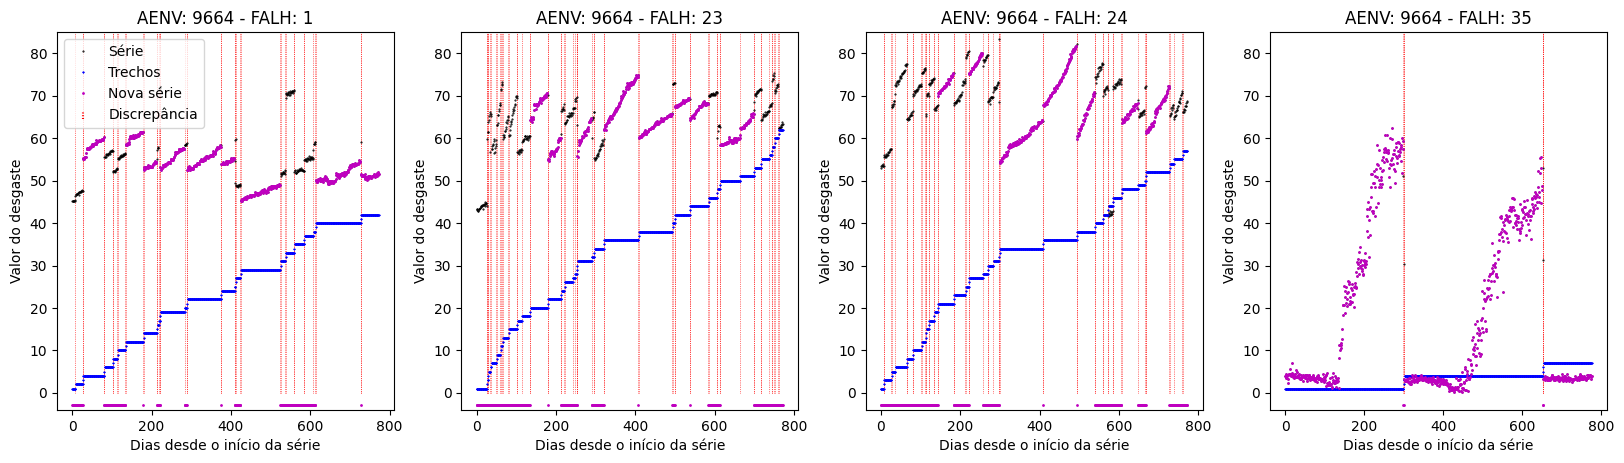

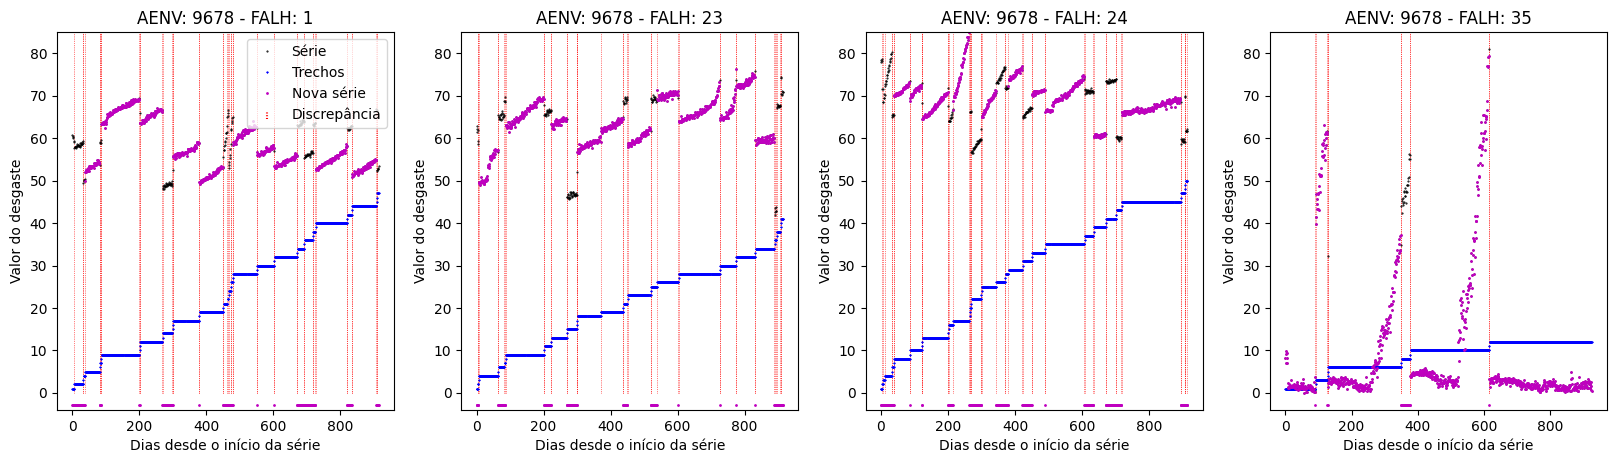

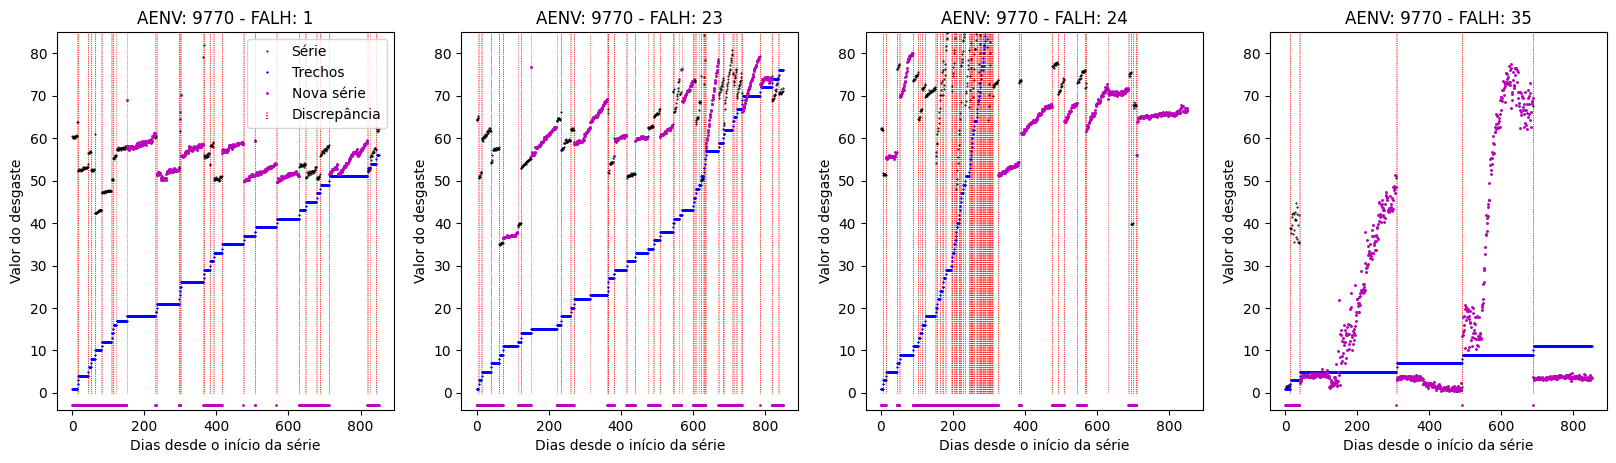

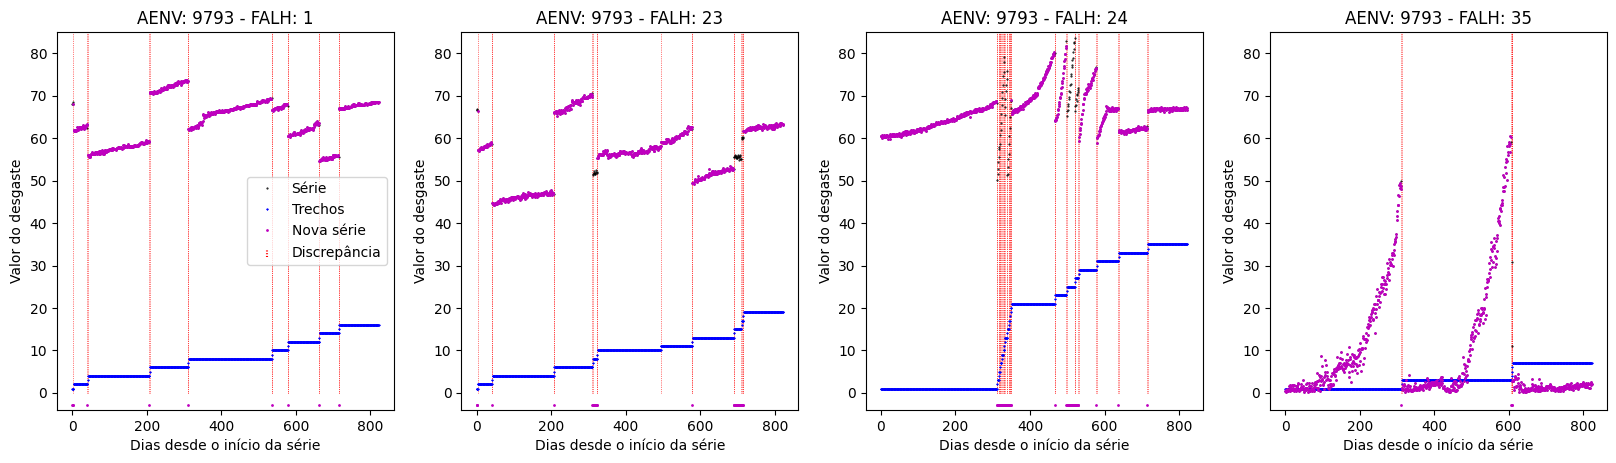

In [28]:
plot_discrepancy(data_health, fun_dis=discrepancy_4,l_train=20)

### Tratamento do banco de dados usando detecção de anomalias

### Vizualizando o resultado da separação dos dados

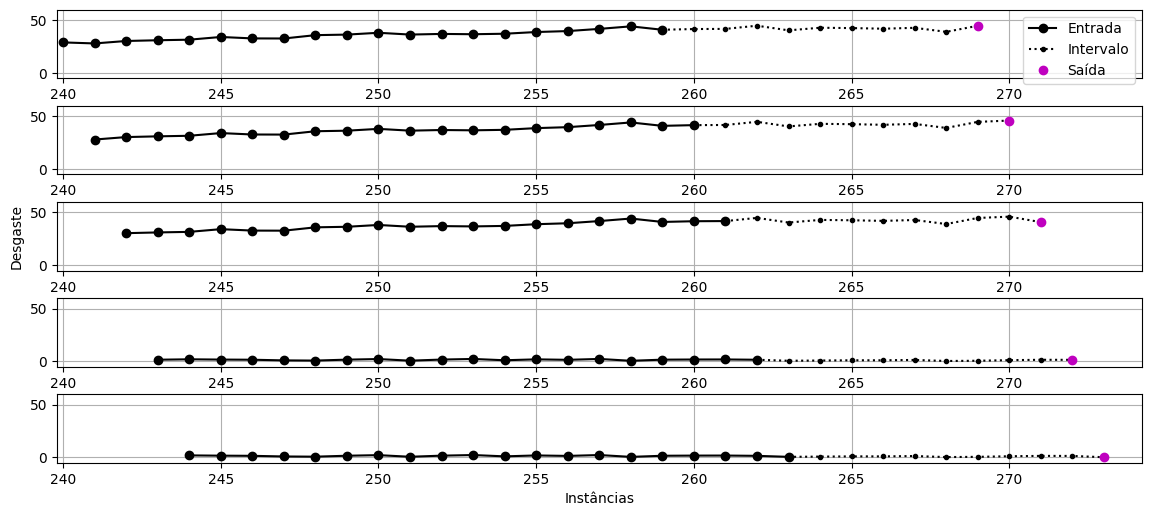

In [10]:

train_test,_ = model_input(data_health, l_train=20,falh = 35)
fig = plt.figure(figsize = (14,6),dpi=100)
axes = gridspec.GridSpec(nrows=5, ncols=1, figure=fig, wspace=0.2, hspace=0.4)

for i in range(5):
    
    ax = fig.add_subplot(axes[i])
    amostra = 240+i

    ax.plot(range(0+amostra,20+amostra),train_test[amostra ,0:20],'-ok',label='Entrada')
    ax.plot(range(19+amostra,30+amostra),train_test[amostra ,19:30],':.k',label='Intervalo')
    ax.plot(29+amostra,train_test[amostra ,29],'om',label='Saída')
   
    if i==0:
        ax.legend()
    if i==2:
        ax.set_ylabel('Desgaste')
    ax.grid()
    ax.set_xlabel("Instâncias")
    ax.set_xlim([239.8,274.2])
    ax.set_ylim([-5,60])
    

### Preparação final para treinar e avaliar os modelos

In [18]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error
def plot_results():

  testPredict = model.predict(testX)

  rmse = mean_squared_error(testY, testPredict, squared = False)*100
  plt.figure(dpi=100,figsize=(20,5))
  plt.plot(testY*100,':ok')
  plt.plot(testPredict*100,'-xm')
  plt.title("Aeronave: "+ str(int(aenv))+' | RMSE='+str(round(rmse,3)))
  plt.xlabel("Dias")
  plt.ylabel("Desgaste")
  plt.legend(["Esperado",'Predito'])
  

aenv = 9526
l_train=20
falh = 35
train_test,_ = model_input(data_health, l_train=l_train,falh = falh)


#### Para treino de modelos comuns do sklearn deep = False

(5116, 20) (5116,) (750, 20) (750,)


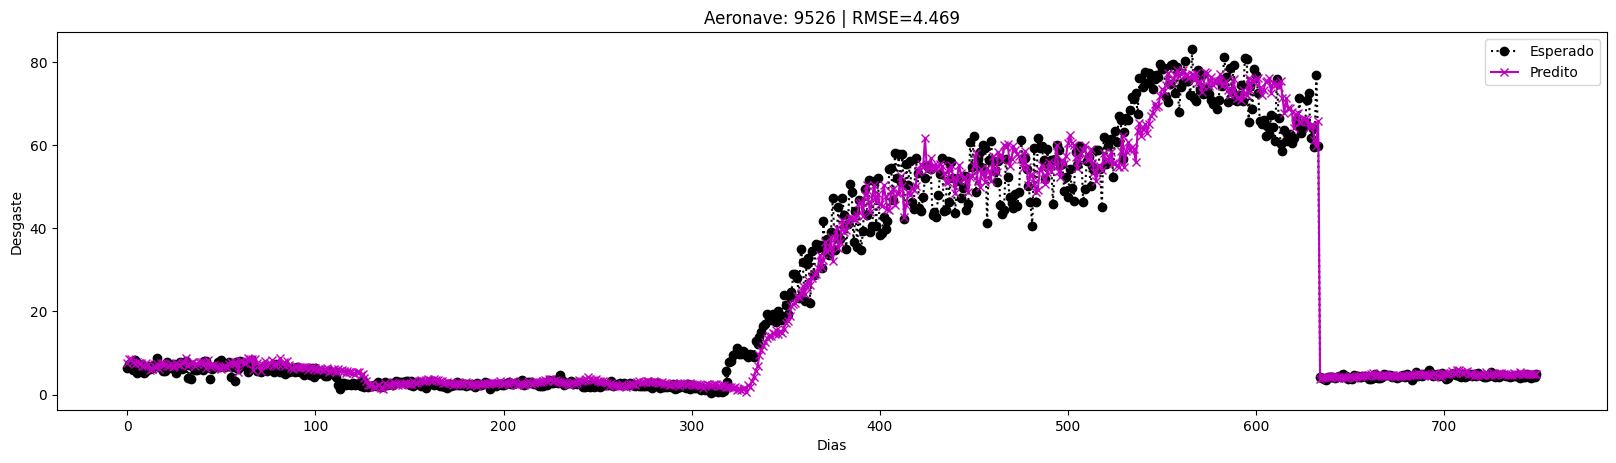

In [19]:
from sklearn.neural_network import MLPRegressor as MLP
from sklearn.svm import SVR


trainX, trainY, testX, testY = data_func(train_test, aenv,l_train,deep=False)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

name='MLP'
model= MLP().fit(trainX, trainY)
plot_results()

#### Para treino de modelos deep do keras deep = True

(5116, 1, 20) (5116, 1, 1) (750, 1, 20) (750, 1, 1)


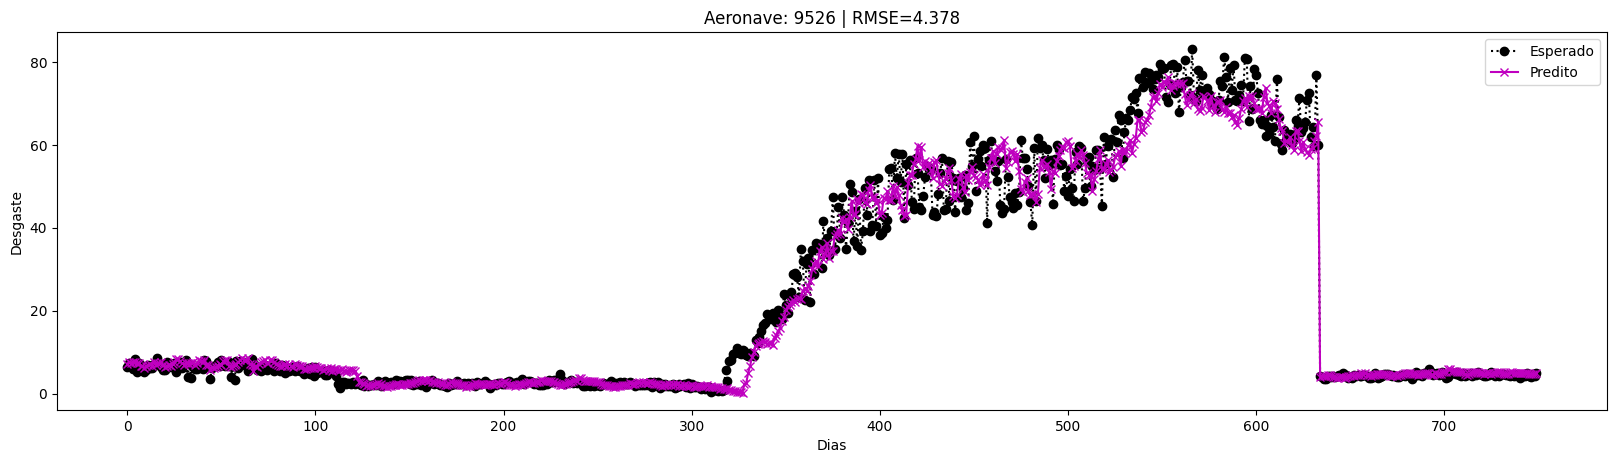

In [20]:
from tensorflow.keras.layers import SimpleRNN as RNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


trainX, trainY, testX, testY = data_func(train_test, aenv,l_train,deep=True)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)


model = Sequential()
model.add(RNN(100, input_shape=(1, l_train)))
model.add(Dense(1))

name='RNN'
early_stopping = EarlyStopping(patience=5)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)
testY=testY[:,0]
plot_results()

### 1D CNN

In [21]:
from keras.layers import (
    Dense,
    Conv1D,
    BatchNormalization,
    MaxPool1D,
    Dropout,
    Flatten,
    Reshape,
)

model = Sequential(
        [
            Reshape(target_shape=(l_train, 1), input_shape=(l_train,)),
            Conv1D(filters=32, kernel_size=3, activation="relu"),
            Conv1D(filters=32, kernel_size=3, activation="relu"),
            #MaxPool1D(pool_size=2),
            Flatten(),
            #BatchNormalization(),
            #Dropout(0.5),
            Dense(units=64, activation="relu"),
            Dense(units=1, activation="sigmoid")
        ]
    )

(5116, 20) (5116,) (750, 20) (750,)


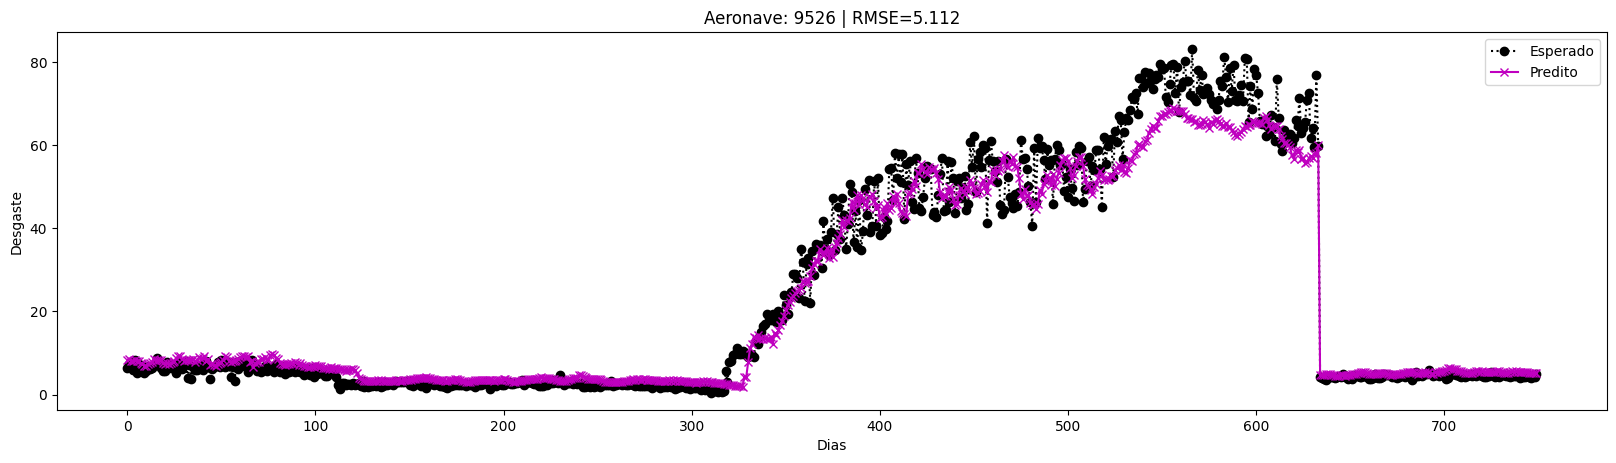

In [24]:

trainX, trainY, testX, testY = data_func(train_test, aenv,l_train,deep=False)
print(trainX.shape, trainY.shape, testX.shape, testY.shape)



name='1DCNN'
early_stopping = EarlyStopping(patience=5)
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=10, validation_split=0.2, callbacks=[early_stopping], verbose=0)
plot_results()